# Computational Methods in Economics

## Lecture 6 - Function Approximation

In [1]:
# Author: Alex Schmitt (schmitt@ifo.de)

import datetime
print('Last update: ' + str(datetime.datetime.today()))

Last update: 2017-12-08 16:00:27.939012


## TO DO

- define orthogonal polynomials

- documentation on Chebyshev nodes interacting with Chebyshev basis

### Preliminaries

#### Import Modules

In [2]:
import numpy as np
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

# import sys
from importlib import reload

## This Lecture

- [Introduction](#introduction)
- [Interpolation vs. Regression](#interp)
- [Choice of Basis Functions: Polynomials](#basis)
- [Chebyshev Polynomials](#cheb)
- [Constructing a Grid](#grid)
- [Univariate Function Approximation in Python](#funapprox1)
- [Multivariate Function Approximation in Python](#funapprox2)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'introduction'></a>

## Introduction

Suppose you are interested in a function $f$, but only have "limited information" about it. That is, you only know its function values at a finite number $m$ points $x_1, x_2,..., x_m$:  
\begin{equation}
    y_1 = f(x_1), y_2 = f(x_2), ..., y_m = f(x_m)
\end{equation}

The goal of function approximation or "curve fitting" is to use this limited information to find a function $\hat{f}$ such that
\begin{equation}
    f(x) \approx \hat{f}(x)
\end{equation}

In this course, we will confine ourselves to functions $\hat{f}$ (also called *approximants*) that are linear combinations of a set of $n + 1$ known *basis functions* $B_0, ..., B_n$:
\begin{equation}
    \hat{f}(x) = \sum_{j = 0}^{n} a_j B_j(x)
\end{equation}

Approximating a function then means to find appropriate values for the $n + 1$ *basis coefficients* $a_0, ..., a_n$ given the "data" $\{y_i, x_i\}_{i = 1}^m$. 

#### Example

For concreteness, consider the following example. Suppose an agent maximizes her utility over two consumption goods. She has an initial endowment $x$ for good 1. Moreover, she can convert good 1 in good 2, using a decreasing-returns-to-scale technology. Formally, we have

\begin{equation}
    \max u(c_1, c_2)
\end{equation}

s.t. 

\begin{equation}
    c_2 = (x - c_1)^\alpha.
\end{equation}

We are interested in computing the *decision rule* (policy function) for good-1 consumption as a function of endowment: $\tilde{c}_1(x)$.

Assume that the utility function $u$ is given by

\begin{equation}
    u(c_1, c_2) = \frac{c_1^{1 - \nu}}{1 - \nu} + \beta \frac{c_2^{1 - \nu}}{1 - \nu}.
\end{equation}

As we have seen before, we cannot solve this problem analytically for this functional form.

Taking first-order conditions and rearranging, we can find an equation in $c_1$:

\begin{equation}
    (x - c_1)^{\alpha\nu - \alpha + 1} = - \alpha \beta c_1^\nu. 
\end{equation}

This expression implicitly determines $c_1$ as a function of $y$. Using a root finding algorithm, we can numerically solve this expression for a finite number of values for $y$, and hence obtain the function values for $\tilde{c}_1(x)$ at these points:
\begin{equation}
    c_1 = \tilde{c}_1(x_1), ..., c_m = \tilde{c}_1(x_m).
\end{equation}

Using this information, we can approximate the function numerically. 

### Some comments

- With respect to terminology, I use "curve fitting" and "function approximation" as synonyms: any problem where we impose a parametric, functional relationship $\hat{f}$ between a *dependent* variable on the left hand side and a (vector of) *explanatory* variables on the right hand side. These variables are "data" (not necessarily from the real world!) in the sense that given those, we want to find the parameters of the function that give a "good fit".

- The first distinction is whether we assume the functional relationship is *linear or nonlinear in the parameters*. Most methods used in empirical or numerical work rely on linear methods, in particular on the use of polynomials. 

- In the example above, the function to approximate ($\tilde{c}_1(x)$) is a univariate function. What follows below also holds for *multivariate* functions, in which case each of the "points" $x_1, x_2,..., x_m$ is actally a vector. For clarity, I will use bold notation in this case: $\mathbf{x}_1, \mathbf{x}_2,..., \mathbf{x}_m$, where 
\begin{equation}
    \mathbf{x}_i = (x_{1i}, x_{2i}, ..., x_{ki}).
\end{equation}
Then, we approximate a function $f(\mathbf{x})$ by:
\begin{equation}
    f(\mathbf{x}) \approx \tilde{f}(\mathbf{x}) \sum_{j = 0}^n a_j B_j(\mathbf{x}),
\end{equation}
using again information on the function values at a finite number of points:
\begin{equation}
    y_i = f(\mathbf{x}_i),\ i = 1,..., m.
\end{equation}

To simplify the exposition, I will first introduce the most important concepts for the univariate case. 

#### Application: Linear regression (e.g. via *Ordinary Least Squares*, OLS)

An application of curve fitting (usually in a multivariate setting) that you all know is linear regression. Let 
Let $y$ denote a dependent variable and $\mathbf{x} = (x_1, ... , x_k)$ a vector of $k$ regressors. Hence, $(y_i, \mathbf{x}_i) = (y_i, x_{1i}, ..., x_{ki})$ corresponds to observation $i$. 

Then, for

\begin{equation}
    B_j(\mathbf{x}) = x_j,\ j = 1,..., k,
\end{equation}

and adding an error term, the problem above becomes

\begin{equation}
    y_i = a_0 + \sum_{j = 1}^k a_j B_j(\mathbf{x}_i) + \epsilon_i = a_0 + a_1 x_{1i} + ... + a_k x_{ki} + \epsilon_i,\ i = 1,..., m
\end{equation}

This is the simplest case of the well-known linear regression model. In this case with $k$ regressors, we need to find $k+1$ coefficients. See below for details on how to implement a regression algorithm. Note that this model can be easily extended to specifications which are nonlinear in the regressors (e.g. $x_{1i}^2$ or $x_{1i} x_{2i}$), but still linear *in the parameters*.






### Preview

Broadly speaking, approximating a function requires the modeller to make three decisions:
1. **choose number and spacing of grid points**; for example, equidistant grid, Chebyshev nodes 
2. **choose basis functions**; for example, monomials, orthogonal polynomials, splines 
3. **choose whether to find the basis coefficients through interpolation or regression (least squares)** 

For ease of exposition, we will go through this list in reverse order, starting with the third point.

  

#### Function approximation along a grid:
In case of linear regression, the function values $y_i = f(\mathbf{x}_i)$ are given. Suppose instead that we can choose the $m$ grid points $\mathbf{x}_i$ at which the function is evaluated. The easiest example in which this is the case is if we either know $f$ (but we still want to obtain an approximation) or at least can evaluate it at given grid points. An application of this is value function iteration.

A second, slightly more complex example for function approximation along a grid would be the case where we do not know $f$ explicitly, but where its values are determined *implicitly* by a functional equation. A prime example is the Euler equation. In the simplest stationary setting, it reads:
\begin{equation}
    c^{-\nu} = \beta (c')^{-\nu} F_k(k')    
\end{equation}
In period $t$, consumption $c$ and next period's capital stock $k'$ are decision variables, whereas the current capital stock $k$ is a state variable. With $c = F(k) - k'$, we are looking for the *policy rule* $k' = \gamma(k)$. The goal is to approximate $\gamma$ linearly:
\begin{equation}
    \gamma(k) \approx \sum_{j = 0}^n a_j B_j(k).
\end{equation}
We cannot evaluate $\gamma$ directly, but its values are pinned down by the Euler equation. At any $k$,
\begin{equation}
    [F(k) - \gamma(k)]^{-\nu} = \beta [F(\gamma(k)) - \gamma(\gamma(k)))]^{-\nu} F_k(\gamma(k))    
\end{equation}
If the number of grid points $m$ equals the degree of approximation $n$ (plus 1), we can use collocation to find the coefficients $a_j$ (see below). The question then is what functional form to use for the basis functions $B_j$. As it turns out, a good answer are Chebyshev polynomials. 



--------------------------------------------------------------------------------------------------------------------------------
<a id = 'interp'></a>

## Interpolation vs. Regression

### Interpolation

A function $\hat{f}(x)$ *interpolates* to the data $\{x_i, f_i\}_{i = 0}^{m}$ if

\begin{equation}
    \hat{f}(x_i) = f_i = f(x_i),\ \ i = 0, 1, ..., m
\end{equation}

In other words, the functions $f$ and $\hat{f}$ have the same function values at the $m$ data points. Note that this results in a system of $m$ equations, the *interpolating conditions*. With
\begin{equation}
    \hat{f}(x) = \sum_{j = 0}^{n} a_j B_j(x), 
\end{equation}
the conditions read
\begin{align}
    f_1 &= \sum_{j = 0}^{n} a_j B_j(x_1) \\
    f_2 &= \sum_{j = 0}^{n} a_j B_j(x_2) \\
    \vdots \\
    f_m &= \sum_{j = 0}^{n} a_j B_j(x_m) \\
\end{align}


Hence, we have $n + 1$ unknowns - the coefficients $a_0, ..., a_n$ - in $m$ equations. In order to get a unique solutions, approximating a function via interpolation requires that
\begin{equation}
    m = n + 1.
\end{equation}
In other words, we need as many data points as coefficients.

We can also write this system of linear equations using matrices:

\begin{equation}
\begin{split}
\left[
\begin{array}{c}
    f_{1}  \\
    \vdots  \\
    f_{m}
\end{array}
\right]
=
\left[
\begin{array}{cccc}
    B_0(x_1) & B_1(x_1) & \cdots & B_n(x_1)  \\
    \vdots & \vdots  & \vdots \\
    B_0(x_m) & B_1(x_m) & \cdots & B_n(x_m) &
\end{array}
\right]
\left[
\begin{array}{c}
    a_{0}  \\
    \vdots  \\
    a_{n}
\end{array}
\right] 
= \Phi
\left[
\begin{array}{c}
    a_{0}  \\
    \vdots  \\
    a_{n}
\end{array}
\right] 
\end{split}
\end{equation}

$\Phi$ is called the *interpolation matrix*. It is a square matrix, since $m = n+1$. 

### Least Squares Regression

The idea of approximating a function $f$ via regression is that instead of requiring the approximant $\hat{f}$ to have the same function values at a given set of points, we minimize the sum of the squares of the differences between $f$ and $\hat{f}$ at these points:

\begin{equation}
    \min R = \sum_{i = 1}^m \left[\ \hat{f}(x_i) - f_i \right]^2.
\end{equation}

Intuitively, the smaller the residual $R$, the closer the approximant $\hat{f}(x)$ fits the data. With

\begin{equation}
    \hat{f}(x) = \sum_{j = 0}^{n} a_j B_j(x), 
\end{equation}

we can write the problem as

\begin{equation}
    \min_{a_0, ..., a_n} \sum_{i = 1}^m \left[ \sum_{j = 0}^{n} a_j B_j(x_i) - f_i \right]^2.
\end{equation}

Be careful not to get confused by the two sums: the outer sum is over all points, the inner sum over all basis functions evaluated at a given point!

Note that in the special case that $m = n + 1$, the *least squares fit* given by the minimizing coefficients $a_0, ..., a_n$ is the same as the coefficients given by interpolation: the residual is zero, its smallest possible value. Least squares regression works also with fewer coefficients: 

\begin{equation}
    m \ge n + 1.
\end{equation}

In other words, we need at least as many data points as degrees of approximation. 

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'basis'></a>

## Choice of Basis Functions: Polynomials 

One of the most frequently used families for basis functions are *polynomials*. Recall that a polynomial $p(x)$ of degree $n$ is defined as
\begin{equation}
    p(x) = a_0 + a_1 x + a_2 x^2 + ... + a_n x^n,
\end{equation}
where $a_0, ..., a_n$ are constants. 

Note that this particular way of writing a polynomial is called its *power series form*. As we will see later, there are other ways of writing a polynomial. The power functions $1, x, x^2, ...$ are also referred to as *monomials*. We can use them as a basis for polynomial interpolation, with $B_j(x) = x^j$. The Vandermonde matrix defined above then reads:
\begin{equation}
\begin{split}
\Phi
=
\left[
\begin{array}{cccc}
    1 & x_1 & \cdots & x_1^n \\
    \vdots & \vdots  & \vdots & \vdots\\
    1 & x_m & \cdots & x^n_m 
\end{array}
\right]
\end{split}
\end{equation}


#### Example

The following example will illustrate *polynomial interpolation* using monomials as basis functions. Assume we want to approximate the function $f(x) = \exp(x)$ using a polynomial of degree 2. Hence, in the case of interpolation, we need $m = 3$ interpolation nodes.

In [3]:
## compare classroom notes
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#


We can verify this result numerically. Start by defining the function:

In [4]:
def fun(x, alpha = 1):
    """
    Exponential function
    """
    y = np.exp(alpha * x)

    return y

We can use Numpy's **linspace** function to construct the grid:

In [5]:
g_min, g_max = 0, 2

x_short = np.linspace(g_min, g_max, 3)
y_short = fun(x_short, alpha) 

In [6]:
A = np.polynomial.polynomial.polyvander(x_short, 2)
print( np.linalg.solve(A, y_short) )

[ 1.          0.24203561  1.47624622]


Unsurprisingly, there is a function in Numpy which combines these steps: **np.polynomial.polynomial.polyfit**

In [7]:
a_mono = np.polynomial.polynomial.polyfit(x_short, y_short, 2)
print(a_mono)

[ 1.          0.24203561  1.47624622]


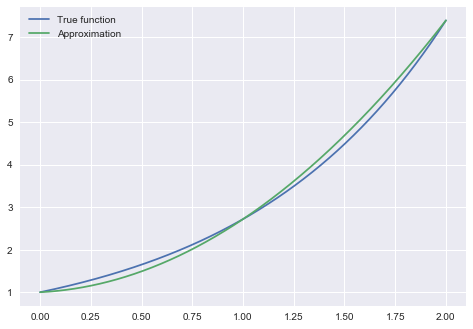

In [9]:
x = np.linspace(g_min, g_max, 1001)
y = fun(x, alpha)
y_mono = np.polynomial.polynomial.polyval(x, a_mono)

fig, ax = plt.subplots()
ax.plot(x, y, label = 'True function')
ax.plot(x, y_mono, label = 'Approximation')
ax.legend()

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'cheb'></a>

## Chebyshev Basis Functions

Recall that in the context of solving systems of linear equations, we saw that the Vandermonde matrix is ill-conditioned for higher orders of $n$. Here's the example again:

In [87]:
for m in [5, 10, 15]:
    ## define matrix
    x = np.linspace(0,1,m)
    A = np.polynomial.polynomial.polyvander(x, m-1)
    ## 
    b = A @ np.ones(m)
    ## solve SLE
    x = np.linalg.solve(A, b)
    
    print("For n = {}, x = {}".format(m, x))
    print("For n = {}, the condition number is {}".format(m, np.linalg.cond(A)))
    print("For n = {}, the determinant is {}".format(m, np.linalg.det(A)))
    print("--------------------------------------------------------------------")

For n = 5, x = [ 1.  1.  1.  1.  1.]
For n = 5, the condition number is 686.4349418185958
For n = 5, the determinant is 0.0002746582031249998
--------------------------------------------------------------------
For n = 10, x = [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For n = 10, the condition number is 15193229.677049411
For n = 10, the determinant is 2.1023615162538136e-22
--------------------------------------------------------------------
For n = 15, x = [ 1.          1.          1.          0.99999999  1.00000006  0.99999958
  1.00000185  0.99999425  1.00001285  0.99997931  1.00002382  0.99998089
  1.00001015  0.9999968   1.00000046]
For n = 15, the condition number is 403235249639.8821
For n = 15, the determinant is 3.1341524226298804e-56
--------------------------------------------------------------------


Hence, it is not recommended to use monomials as basis functions for function approximation. Instead, we usually rely on basis functions that are constructed from **orthogonal** polynomials, in particular Chebyshev polynomials.

#### Chebyshev Polynomials

Let $n$ be the degree of approximation. Then for $j = 0, ..., n$, the **Chebyshev polynomials** $T_j(x)$ are defined as  

\begin{equation*}
  T_j(x) = \cos(j \cos^{-1}(x)),
\end{equation*} 

for $x \in [-1,1]$. Their first derivatives are given by:

\begin{equation*}
  T'_j(x) = -\sin(j \cos^{-1}(x)) \frac{-j}{\sqrt{1-x^2}} = \sin(j \cos^{-1}(x)) \frac{j}{\sqrt{1-x^2}}. 
\end{equation*} 

An alternative way to define the Chebyshev polynomials is the following recurrence relationship: 

\begin{equation}
	T_{j+1}(x) = 2x T_j(x) - T_{j-1},
\end{equation}

for $j \ge 1$, with $T_0(x) = 1$ and $T_1(x) = x$. Writing down the first few Chebyshev polynomials, we can see that the polynomial $T_n(x)$ has exact degree $n$ and if $n$ is even (odd) then $T_n(x)$ involves only even (odd) powers of $x$. For example,

\begin{align}
T_4(x) &= 8x^4 - 8x^2 + 1 \\
T_5(x) &= 16x^5 - 20x^3 + 5x 
\end{align}

A (univariate) polynomial $p_n(x)$ that is *represented by a Chebyshev polynomial basis* rather than a power series (monomial) basis is also referred to as a **Chebyshev series**:

\begin{equation}
    p_n(x) = \sum_{j = 0}^n a_j T_j(x)
\end{equation}

This is a polynomial of degree $n$.

#### In Python

In [83]:
m = 15

In [88]:
x = np.linspace(0, 1, m)
V = np.polynomial.polynomial.polyvander(x, m-1)
print( np.linalg.det(V) )
print( np.linalg.cond(V) )

3.13415242263e-56
403235249640.0


In [89]:
x = np.linspace(-1,1,m)
V = np.polynomial.chebyshev.chebvander(x, m-1)
print( np.linalg.det(V) )
print( np.linalg.cond(V) )

3147.74911409
225.73172355


In [90]:
x = chebnodes(m)
V = np.polynomial.chebyshev.chebvander(x, m-1)
print( np.linalg.det(V) )
print( np.linalg.cond(V) )

5169808.70249
1.41421356237


Recall that in the case of regression, we need to compute the matrix $Q = V'V$. If each element of $V$ is an orthogonal polynomial, the result $Q$ is a *diagonal* matrix.

In [91]:
V.T @ V

array([[  1.50000000e+01,  -2.22044605e-16,   2.22044605e-16,
          1.33226763e-15,   8.88178420e-16,   3.66373598e-15,
          1.11022302e-15,   5.44009282e-15,   5.55111512e-16,
          5.44009282e-15,  -7.77156117e-16,   1.28785871e-14,
          7.88258347e-15,   5.44009282e-15,   1.07691633e-14],
       [ -2.22044605e-16,   7.50000000e+00,   7.66592980e-16,
         -5.00407095e-17,   2.56655313e-15,   9.39712835e-16,
          4.63782774e-15,   9.01673952e-16,   5.58711336e-15,
          7.46244451e-18,   9.18444151e-15,   3.69783151e-15,
          9.27582858e-15,   9.31679763e-15,   1.51952919e-14],
       [  2.22044605e-16,   7.66592980e-16,   7.50000000e+00,
          9.19745499e-16,   2.66382488e-16,   3.65917635e-15,
          6.96193148e-16,   4.71442233e-15,   3.26988046e-16,
          9.07962739e-15,   4.26407576e-15,   5.54661374e-15,
          4.70454809e-15,   1.90168233e-14,   9.85072590e-15],
       [  1.33226763e-15,  -5.00407095e-17,   9.19745499e-16,
     

In [ ]:
# ## min and max for approximation grid
# g_min, g_max = 0, 2
# ## number of grid points
# m = 9
# ## Chebyshev grid and function values
# p_nodes = chebgrid(g_min, g_max, m)
# y = fun(p_nodes, alpha) 

# a1 = get_coef(y, m-1)          

x_short = np.linspace(g_min, g_max, 10)
y_short = fun(x_short, alpha) 


a_mono = np.polynomial.polynomial.polyfit(x_short, y_short, 9)
y_mono = np.polynomial.polynomial.polyval(x, a_mono)

ax[0].plot(x, y_mono)
ax[1].plot(x, y - y_mono)


a_cheb = np.polynomial.chebyshev.chebfit(x_short, y_short, 9)
y_cheb = np.polynomial.chebyshev.chebval(x, a_cheb)

ax[0].plot(x, y_cheb)
ax[1].plot(x, y - y_cheb)

Boyd's Moral Principle (via J. Fernandez-Villaverde):
1. When in doubt, use Chebyshev polynomials (unless the solution is spatially periodic, in which case an ordinary Fourier series is better).
2. Unless you are sure that another set of basis functions is better, use Chebyshev polynomials.
3. Unless you are really, really sure that another set of basis functions is better, use Chebyshev polynomials.

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'grid'></a>

## Constructing a Grid

Many approximation problems outside of Econometrics (where the data points/observations are given by the "real world") allow the modeler to choose the interpolation grid $x_1, x_2,..., x_m$. In the simple example above, we used three equally spaced points between 0 and 2 (i.e. 0,1,2). The two features that characterize such a grid are the number of grid points and their spacing. Both have an impact on the quality of the approximation. For the number of grid points, this is intuitive: the more data you have, the more information about the function is available. However, note that at least in the case of interpolation, the number of basis functions and coefficients increases with the number of grid points, and hence more points mean a larger system of linear equations to solve. 

Why the spacing of grid points matters is less obvious.  

### Chebyshev Nodes

Let $m$ be the number of grid points, indexed by $i$. The Chebyshev nodes between $-1$ and $1$ are given by

\begin{equation}
	z_i = \cos\left(- \frac{(2i - 1)\pi}{2m}\right).
\end{equation}

The Chebyshev nodes on $[a,b]$ are given by

\begin{equation}
    y_i = a + \frac{(z_i + 1) (b-a)}{2}.
\end{equation}

In [4]:
def chebnodes(m):
    """ 
    Computes m Chebyshev nodes between -1 and 1.
    """
    i = np.array(list(range(1, m+1)))
    return -np.cos(0.5 * np.pi * (2 * i - 1) / m)

def chebgrid(a, b, m):
    """ 
    Computes num Chebyshev nodes on the interval [a,b].
    """
    z = chebnodes(m)
    return (b - a) * 0.5 * (z + 1) + a 

def convert(x, a, b):
    """
    Transforms nodes between [a,b] to the interval [-1,1].
    """
    return 2. * (x - a) / (b - a) - 1


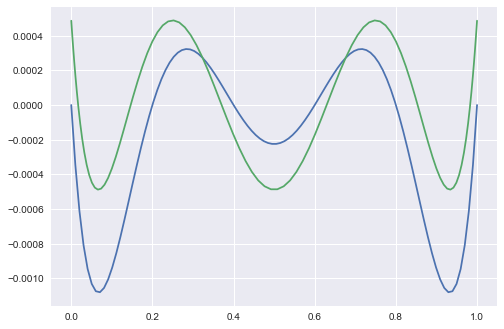

In [12]:
def eval_omega(x, nodes):
    return np.prod([(x - node) for node in nodes], axis = 0)

N = 5
nodes = np.linspace(0, 1, N+1)
x = np.linspace(0, 1, 100)


fig, ax = plt.subplots()
ax.plot(x, eval_omega(x, nodes))

nodes = chebgrid(0, 1, N+1)
x = chebgrid(0, 1, 100)


ax.plot(x, eval_omega(x, nodes))

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'funapprox1'></a>

## Univariate Function Approximation in Python

### Chebyshev Basis Functions

Let $n$ be the degree of approximation. Recall that for $j = 0, ..., n$, the Chebyshev polynomials $T_j(x)$ are defined as: 

\begin{equation}
	T_{j+1}(x) = 2x T_j(x) - T_{j-1},
\end{equation}

for $j \ge 1$, with $T_0(x) = 1$ and $T_1(x) = x$. A Chebyshev series reads:

\begin{equation}
    p_n(x) = \sum_{j = 0}^n a_j T_j(x)
\end{equation}

This is a polynomial of degree $n$.

#### "Chebyshev Matrix"

The following Python function gives the Chebyshev polynomials evaluated either at the Chebyshev nodes or for a scalar or array **x**. Hence, with approximation degree **deg**, this results in an **m**-by-**deg** array, where **m** is either provided directly (in case of Chebyshev nodes) or is the length of the input **x**. Note that this type of matrix is also referred to as a *(Pseudo-)Vandermonde matrix*.

In [5]:
def chebmatrix(deg, m = None, x = None):
    """
    Computes the m-by-(deg+1) matrix with Chebyshev basis functions of degree deg for m Chebyshev nodes.
    """
    ## check if a second argument is provided
    assert (m != None or np.sum(x) != None), "Please provide the number of grid points or an input vector/scalar x!"
    
    ## check if x values are provided
    if x is None: # default: Chebyshev nodes between -1 and 1 (for interpolation/regression) 
        z = chebnodes(m)
    elif isinstance(x, (list, tuple, np.ndarray)):    # arbitrary vector (for approximation)
        z, m  = x, len(x) 
    else:    # arbitrary scalar (for approximation)
        z, m = x, 1 

    ## define numpy array and fill second column     
    T = np.ones((m, deg + 1))
    T[:,1] = z
    
    ## loop over columns in T; each column corresponds to the Chebyshev basis functions for deg col_idx
    for col_idx in range(1, deg):
        T[:,col_idx+1] = 2 * z * T[:,col_idx] - T[:,col_idx - 1]
    return T



## Examples for different ways to use chebmatrix function
print(chebmatrix(4, 2))
print(chebmatrix(4, x = 0.1))
print(chebmatrix(4, x = np.array([0.1, 0.2])))
# print(chebmatrix(4)) -> only one argument, throws an error!

[[  1.00000000e+00  -7.07106781e-01   2.22044605e-16   7.07106781e-01
   -1.00000000e+00]
 [  1.00000000e+00   7.07106781e-01  -2.22044605e-16  -7.07106781e-01
   -1.00000000e+00]]
[[ 1.      0.1    -0.98   -0.296   0.9208]]
[[ 1.      0.1    -0.98   -0.296   0.9208]
 [ 1.      0.2    -0.92   -0.568   0.6928]]


Note that we could also have used the direct definition of the Chebyshev polynomials to find this matrix, rather than the recursive formula. However, computing the Chebyshev matrix recursively is computationally more efficient, in particular for higher values of **m** and **deg**. Finally, Numpy's **polynomial.chebyshev** package has a method **chebvander** that gives the same matrix. 

In [7]:
## Use Numpy's polynomial.chebyshev package
print( np.polynomial.chebyshev.chebvander(chebnodes(2), 4) )
print( np.polynomial.chebyshev.chebvander(np.array([0.1, 0.2]), 4) )

[[  1.00000000e+00  -7.07106781e-01   2.22044605e-16   7.07106781e-01
   -1.00000000e+00]
 [  1.00000000e+00   7.07106781e-01  -2.22044605e-16  -7.07106781e-01
   -1.00000000e+00]]
[[ 1.      0.1    -0.98   -0.296   0.9208]
 [ 1.      0.2    -0.92   -0.568   0.6928]]


Finally, note that if the Chebyshev polynomials are evaluated at $m$ Chebyshev nodes, the following holds: 
\begin{equation}
\sum _{k=1}^{m}{T_{i}(x_{k})T_{j}(x_{k})}={\begin{cases}0\ \text{if}\ i\neq j\\m\ \text{if}\ i=j=0\\{\frac {m}{2}}\ \text{if}\ i=j\neq 0\end{cases}}
\end{equation}
We can confirm this numerically:

In [5]:
m = 9
T = chebmatrix(m-1, m)
print(np.sum(T[:,2] * T[:,3]), np.sum(T[:,5] * T[:,7]), np.sum(T[:,0] * T[:,m-1]))
m = 12
T = chebmatrix(m-1, m)
print(np.sum(T[:,0] * T[:,0]), np.sum(T[:,5] * T[:,5]), np.sum(T[:,7] * T[:,7]))

5.55111512313e-16 -1.38777878078e-16 3.21964677141e-15
12.0 6.0 6.0


This property comes from the orthogonality of Chebyshev polynomials. It will be useful in the next step, finding the coefficients of the approximating function using interpolation or regression.

#### Regression/interpolation

The following function uses **chebmatrix** to computes the Chebyshev basis functions (by default at the Chebyshev nodes) and then solves the resulting system of linear equations using either interpolation (if the approximation degree corresponds to the length of the data vector **y**) or regression.

In [9]:
def get_coef(y, deg, v = None):
    """
    Function to compute the Chebyshev coefficients using interpolation or regression
    """
    m = len(y)
    if v == None:
        T = chebmatrix(deg, m)
    else:
        z = convert(v[0], v[1], v[2]) 
        T = chebmatrix(deg, x = z)

    
    if deg == m-1: # interpolation (default)
        coef = np.linalg.solve(T,y)
    else:
        coef = np.ones(deg + 1)
        for idx_deg in range(deg + 1):
            coef[idx_deg] = sum(y * T[:,idx_deg]) / sum(T[:,idx_deg]**2)
            
    return coef        
            


Again, there is a Numpy function, **np.polynomial.chebyshev.chebfit**, that does the same (but not with the default Chebyshev nodes). We will see its use below. 

--------------------------------------------------------------------------------------------------------------------------------

## Example 1: Function Approximation for known functions

Below I approximate the function $y = \exp(-\alpha x)$ between 0 and 2 (compare the Matlab example by Miranda and Fackler for a different interval).

In [ ]:
def fun(x, alpha = 2):
    """
    Exponential function
    """
    y = np.exp(-alpha * x)
#     yd = -alpha * np.exp(-alpha * x)
    return y

In [12]:
## min and max for approximation grid
g_min, g_max = 0, 2
## number of grid points
m = 9
## Chebyshev grid and function values
p_nodes = chebgrid(g_min, g_max, m)
y = fun(p_nodes) 

a1 = get_coef(y, m-1)            
a2 = np.polynomial.chebyshev.chebfit(convert(p_nodes, g_min, g_max), y, m-1)    

print(a1)
print(a2) 

[  3.08508323e-01  -4.30538578e-01   1.86478067e-01  -5.75824453e-02
   1.37307308e-02  -2.65952214e-03   4.33119221e-04  -6.07958356e-05
   7.41574370e-06]
[  3.08508323e-01  -4.30538578e-01   1.86478067e-01  -5.75824453e-02
   1.37307308e-02  -2.65952214e-03   4.33119221e-04  -6.07958356e-05
   7.41574370e-06]


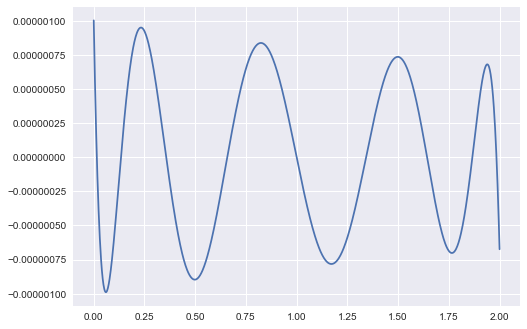

In [11]:
## interpolate over wide grid and plot
x = np.linspace(g_min, g_max, 1001)
y_approx2 = np.polynomial.chebyshev.chebval(convert(x, g_min, g_max), a2) 
y_approx1 = chebmatrix(m-1, x = convert(x, g_min, g_max)) @ a1

## plot approximation errors
fig, ax = plt.subplots()
ax.plot(x, fun(x) - y_approx2)

## Example 2: Using Functional Equation

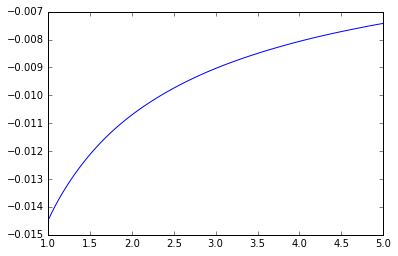

In [37]:
def residual_ee(a, k, alpha, beta, delta, nu):
    
    k_p = np.polynomial.chebyshev.chebval(k, a)
    k_pp = np.polynomial.chebyshev.chebval(k_p, a)
    return (k_p**alpha - k_pp)**(nu) - beta * (k**alpha - k_p)**nu * ( alpha * k_p**(alpha - 1) + 1 - delta)

m = 10
k = chebgrid(1, 5, m)    
alpha, beta, delta, nu = 0.3, 0.95, 1, 1    
## initial guess: analytical policy function from log/full depreciation
a_init = np.polynomial.chebyshev.chebfit(k, alpha * beta * k**alpha, m-1)

## collocation
a = scipy.optimize.fsolve(residual_ee, a_init, args=( k, alpha, beta, delta, nu ))

## interpolate over long grid
k_long = np.linspace(1, 5, 100)
k_approx = np.polynomial.chebyshev.chebval(k_long, a) 


## plot approximation errors
fig, ax = plt.subplots()
# ax.plot(k_long, alpha * beta * k_long**alpha)
# ax.plot(k_long, k_approx)
ax.plot(k_long, (alpha * beta * k_long**alpha - k_approx)/(alpha * beta * k_long**alpha))

## Example 3: Derivatives 

Suppose you have a function $f$ approximated by a Chebyshev series:
\begin{equation}
   f(x) \approx p_n(x) = \sum_{j = 0}^n a_j T_j(x)
\end{equation}
Then, the derivative of $f$ can be approximated by the derivative of $p_n$, which makes use of the derivatives of the Chebyshev basis functions:
\begin{equation}
   f'(x) \approx p'_n(x) = \sum_{j = 0}^n a_j T'_j(x)
\end{equation}
As an example, consider $n = 3$ and recall the Chebyshev basis functions from above:
\begin{equation}
   p_3(x) = \sum_{j = 0}^3 a_j T_j(x) = a_0 + a_1 x + a_2 (2x^2 - 1) + a_3 (4x^3 - 3x)
\end{equation}
Taking the first derivative w.r.t. $x$ gives:
\begin{equation}
   \frac{\partial p_3(x)}{\partial x} = a_1 + 4a_2x + 12a_3 x^2 - 3a_3 = (a_1 + 3a_3) + (4 a_2) x + (6a_3) (2x^2 - 1)
\end{equation}
Using the last rearrangement, we can see that this can be expressed as a Chebyshev series with $n = 2$: 
\begin{equation}
   \frac{\partial p_3(x)}{\partial x} = (a_1 + 3a_3) T_0(x) + (4 a_2) T_1(x) + (6a_3) T_2(x)
\end{equation}
In other words, for a Chebyshev series with parameters $(a_0, a_1, a_2, a_3)$, the first derivative is a Chebyshev series with coefficients $(a_1 + 3a_3, 4 a_2, 6a_3)$. An analogous argument can be made for any Chebyshev series of degree $n$: its first derivative is a Chebyshev series of degree $n -1$. The Numpy function **chebder** takes the $n+1$ coefficients $(a_0, ..., a_n)$ as an input and computes the $n$ coefficients to be used for the approximation of the first derivative: 

In [8]:
import numpy as np
print(np.polynomial.chebyshev.chebder([1,2,3,4]))

[ 14.  12.  24.]


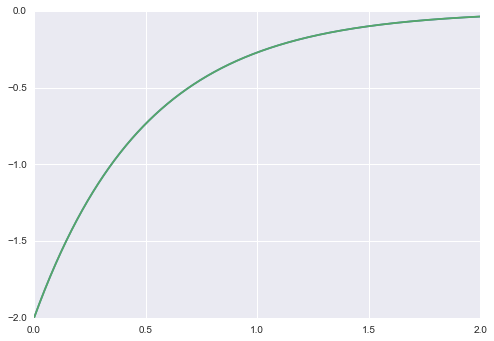

In [9]:
def fun(x, alpha):
    """
    Exponential function
    """
    y = np.exp(-alpha * x)
#     yd = -alpha * np.exp(-alpha * x)
    return y

def fun_d(x, alpha):
    """
    Exponential function
    """
    y = -alpha * np.exp(-alpha * x)
#     yd = -alpha * np.exp(-alpha * x)
    return y

## parameters
alpha = 2
## min and max for approximation grid
g_min, g_max = 0, 2
## number of grid points
m = 9
## Chebyshev grid and function values
p_nodes = chebgrid(g_min, g_max, m)
y = fun(p_nodes, alpha) 
          
a = np.polynomial.chebyshev.chebfit(convert(p_nodes, g_min, g_max), y, m-1)    

## Coefficients to approximate derivative
ad = np.polynomial.chebyshev.chebder(a)

## interpolate over wide grid
x = np.linspace(g_min, g_max, 1001)
yd_approx = np.polynomial.chebyshev.chebval(convert(x, g_min, g_max), ad) 


## plot approximation errors
fig, ax = plt.subplots()
# ax.plot(x, fun_d(x, alpha) - yd_approx)
ax.plot(x, fun_d(x, alpha))
ax.plot(x, yd_approx)

--------------------------------------------------------------------------------------------------------------------------------
<a id = 'funapprox2'></a>

## Multivariate Function Approximation in Python

Recall that in general, the problem we want to solve is 
\begin{equation}
    y_i \approx \sum_{j = 0}^n a_j B_j(\mathbf{x}_i),\ i = 1,..., m
\end{equation}

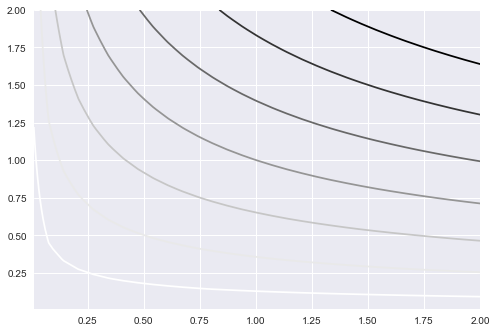

In [26]:
## Example
def cd_fun(x, y, alpha = 0.33):
    """
    Cobb-Douglas Function
    """
    return x**alpha * y**(1 - alpha)

N = 31
## min and max for approximation grid
g_min, g_max = 0.01, 2
## interpolate over equidistant grid
x = np.linspace(g_min, g_max, N)
y = np.linspace(g_min, g_max, N)
## use meshgrid function 
X, Y = np.meshgrid(x,y)
Z = cd_fun(X, Y)

## plot contour
fig, ax = plt.subplots()
ax.contour(X, Y, Z)

In [14]:
Z

array([[ 0.01      ,  0.01955671,  0.02403956,  0.02726769,  0.02986437,
         0.03206925,  0.03400305,  0.03573614,  0.03731357,  0.03876611,
         0.04011584,  0.04137918,  0.04256872,  0.04369434,  0.04476399,
         0.04578411,  0.04676007,  0.04769633,  0.0485967 ,  0.04946441,
         0.05030228,  0.05111272,  0.05189789,  0.05265965,  0.05339968,
         0.05411944,  0.05482029,  0.05550339,  0.05616984,  0.05682062,
         0.0574566 ],
       [ 0.0390318 ,  0.07633333,  0.0938307 ,  0.10643067,  0.11656601,
         0.12517206,  0.13272   ,  0.13948456,  0.14564155,  0.1513111 ,
         0.15657934,  0.16151038,  0.16615335,  0.17054687,  0.17472188,
         0.17870361,  0.18251294,  0.18616734,  0.18968163,  0.19306848,
         0.19633881,  0.19950214,  0.20256679,  0.20554008,  0.20842853,
         0.21123791,  0.21397342,  0.21663971,  0.21924098,  0.22178106,
         0.22426341],
       [ 0.05934663,  0.11606246,  0.14266667,  0.16182453,  0.177235  ,
       

### chebfit in the multidimensional case

*Key insight*: we do not a 2- or n-dimensional Chebyshev-Vandermonde matrix in order to implement the fitting step. Such a matrix is needed to approximate a function for a given coefficient vector. In the 2-D or 3-D case, functions for this are already implemented in the **polynomial.chebyshev** package.

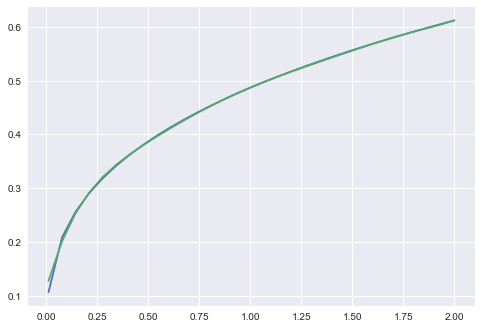

In [27]:
## two dimensions
def chebfit_2d(Z, deg):
    """
    Computes the (deg[0]+1)-by-(deg[1]+1) coefficient matrix for interpolation with Chebyshev basis functions
    NB: Z must be a m1-by-m2 "meshgrid" matrix
    """
    ## get the dimensions of the grid
    m = Z.shape
    ## check of dimension are consistent
    assert len(m) == len(deg), "Inconsistent dimensions"

    ## define Chebyshev matrices    
    A, B = chebmatrix(deg[0], m[0]), chebmatrix(deg[1], m[1])
    
    ## Tensor interpolation in two dimensions
    coef = np.zeros(np.array(deg) + 1)
    for idx_A in range(deg[0] + 1):
        for idx_B in range(deg[1] + 1):    
            den = (A[:, idx_A].T @ A[:, idx_A]) * (B[:, idx_B].T @ B[:, idx_B])
            coef[idx_A, idx_B] = (A[:, idx_A].T @ Z) @ B[:, idx_B] / den
    
    return coef

# check if it runs for different grid lenghts
Y_c, X_c = np.meshgrid(chebgrid(g_min, g_max, 10), chebgrid(g_min, g_max, 8))
Z_c = cd_fun(X_c, Y_c)            
# print(Z_c.shape)
coef = chebfit_2d(Z_c, [7,9])

z_app = np.zeros(N)
for idx in range(N):
    z_app[idx] = np.polynomial.chebyshev.chebval2d(convert(x[idx], g_min, g_max), convert(y[5], g_min, g_max), coef)


fig, ax = plt.subplots()
ax.plot(x, cd_fun(x, y[5]))
ax.plot(x, z_app)


In [28]:
coef

array([[  8.43214002e-01,   6.63180827e-01,  -7.85608967e-02,
          2.68374673e-02,  -1.24324964e-02,   6.66291362e-03,
         -3.84930795e-03,   2.27797165e-03,  -1.29105408e-03,
          5.86964071e-04],
       [  3.96390045e-01,   3.11757487e-01,  -3.69310250e-02,
          1.26161388e-02,  -5.84444492e-03,   3.13219732e-03,
         -1.80953750e-03,   1.07086135e-03,  -6.06917088e-04,
          2.75928429e-04],
       [ -1.04705165e-01,  -8.23497451e-02,   9.75521240e-03,
         -3.33251280e-03,   1.54379147e-03,  -8.27359924e-04,
          4.77983554e-04,  -2.82864608e-04,   1.60315212e-04,
         -7.28856138e-05],
       [  4.71117850e-02,   3.70530286e-02,  -4.38932948e-03,
          1.49945445e-03,  -6.94624490e-04,   3.72268195e-04,
         -2.15067312e-04,   1.27274109e-04,  -7.21333640e-05,
          3.27946702e-05],
       [ -2.53340100e-02,  -1.99249889e-02,   2.36032909e-03,
         -8.06320416e-04,   3.73529123e-04,  -2.00184437e-04,
          1.15650838e-04

In [29]:
 np.polynomial.chebyshev.chebval2d(convert(1.1, g_min, g_max), convert(0.8, g_min, g_max), coef)

0.88986168524684561

In [43]:
F = np.polynomial.chebyshev.chebvander2d(convert(1.1, g_min, g_max), convert(0.8, g_min, g_max), [7,9]) 
F

array([[ 1.        , -0.20603015, -0.91510315,  0.58310783,  0.67482756,
        -0.86117748, -0.31997051,  0.99302463, -0.08921552, -0.95626246,
         0.09547739, -0.01967122, -0.08737166,  0.05567361,  0.06443077,
        -0.08222298, -0.03054995,  0.0948114 , -0.00851806, -0.09130144,
        -0.98176814,  0.20227384,  0.89841912, -0.57247669, -0.6625242 ,
         0.84547661,  0.31413685, -0.97491994,  0.08758895,  0.93882801,
        -0.2829507 ,  0.05829638,  0.25892908, -0.16499077, -0.19094293,
         0.24367077,  0.09053588, -0.28097701,  0.02524359,  0.27057513,
         0.92773735, -0.19114187, -0.84897538,  0.54097092,  0.62606274,
        -0.79894652, -0.29684859,  0.92126604, -0.08276857, -0.8871604 ,
         0.46010658, -0.09479583, -0.42104498,  0.26829175,  0.3104926 ,
        -0.39623342, -0.14722054,  0.45689716, -0.04104865, -0.43998264,
        -0.8398778 ,  0.17304015,  0.76857483, -0.48973933, -0.56677269,
         0.72328385,  0.26873613, -0.83401934,  0.0

In [41]:
F @ coef.flatten()

array([ 0.88986169])

In [17]:
## three dimensions
def chebfit_3d(Z, deg):
    
    m = Z.shape
    assert len(m) == len(deg), "Inconsistent dimensions"
    
    A, B, C = chebmatrix(deg[0], m[0]), chebmatrix(deg[1], m[1]), chebmatrix(deg[2], m[2])
    
    coef = np.zeros(np.array(deg) + 1)
    for idx_A in range(deg[0] + 1):
        for idx_B in range(deg[1] + 1):
            for idx_C in range(deg[2] + 1):
                den = (A[:, idx_A].T @ A[:, idx_A]) * (B[:, idx_B].T @ B[:, idx_B]) * (C[:, idx_C].T @ C[:, idx_C])
                coef[idx_A, idx_B, idx_C] = ((B[:, idx_B].T @ Z) @ C[:, idx_C]) @ A[:, idx_A] / den
                
    return coef

## check if it runs for different grid lenghts
X_c, Y_c, W_c = np.meshgrid(chebgrid(g_min, g_max, 10), chebgrid(g_min, g_max, 8), chebgrid(g_min, g_max, 12))
Z_c = cd_fun(X_c, Y_c)  # just for test purposes
# print(Z_c.shape)
coef = chebfit_3d(Z_c, [7,9,11])

# ## example from OCIT, can be compared with AMPL implementation 
# V = np.loadtxt('ocit_scenarios/results/add_sep_baseline/vf_mickey_g_131313_iota003.txt') 
# V.shape = (13, 13, 13)
# coef = chebfit_3d(V, [12,12,12])
# coef[:,1,1]


In [25]:
coef

array([[[  8.42931866e-01,  -7.23957931e-17,  -1.01002171e-16,
           3.93203988e-17,  -6.43705858e-17,   4.81096644e-17,
          -2.97909845e-16,  -1.25825276e-16,  -4.82725398e-16,
           4.11245112e-16,  -3.23827795e-16,  -3.24740235e-16],
        [  3.97203988e-01,  -3.51570624e-17,  -4.83532486e-17,
           1.78098277e-17,  -2.79179185e-17,   1.52655666e-17,
          -1.38777878e-16,  -6.33752310e-17,  -2.27638333e-16,
           2.01170099e-16,  -1.55900938e-16,  -1.66533454e-16],
        [ -1.05565881e-01,   1.15648232e-17,   1.30057585e-17,
          -5.89805982e-18,   7.38612237e-18,  -3.46944695e-18,
           3.96095194e-17,   1.65376971e-17,   6.03665019e-17,
          -5.16369355e-17,   4.02754356e-17,   3.97251676e-17],
        [  4.81064281e-02,  -4.27898457e-18,  -6.09383819e-18,
           2.28405258e-18,  -3.69221435e-18,   4.62592927e-19,
          -1.56992475e-17,  -6.56303715e-18,  -2.73512925e-17,
           2.43656368e-17,  -1.83217936e-17,  -1.989

### Generating the Chebyshev matrix 

In [34]:
F = np.polynomial.chebyshev.chebvander2d(np.array([0.1, 0.2]), np.array([0.3, 0.4]), [4, 5]) 

In [77]:
deg_A = 3
deg_B = 3
m_A = 6
m_B = 6
A = chebmatrix(deg_A, m_A)
B = chebmatrix(deg_B, m_B)

C = np.tile(A.T, m_B)
C = C.T

D = np.repeat(B, m_A, axis = 0)

E = np.tile(C, deg_B + 1) 
F = np.repeat(D, deg_A + 1)
F.shape = E.shape
G = E * F
E.shape

(36, 16)

In [78]:
np.sum(E)

143.99999999999994

In [ ]:
def chebmatrixnd(num, deg = None, z = None):
	"""
	Computes the num-by-(deg+1) matrix with Chebyshev basis functions of degree deg for num Chebyshev nodes.
	INPUTS:
		num: list of length DIM containing the lengths of the approximation grids for dimensions 0,...,dim-1
		deg (optional): degree of approximation
			deg = None: matrix is the tensor product of one-dimensional basis functions -> matrix has dimension prod(num)-by-prod(num)
			deg = x < prod(num): matrix is the complete product of one-dimensional basis functions
		z (optional): dictionary of n-dimensional grid vectors
			z = None: function defines n-dimensional grid vectors using Chebyshev nodes 

	"""
	# number of dimensions
	dim = len(num)

	# check if z is given, otherwise define a dictionary of Chebyshev nodes
	if z is None: # default: Chebyshev nodes between -1 and 1 (for interpolation/regression) 
		z = {}
		for idx in range(dim):
			z[idx] = chebnodes(num[idx])
		len_T = np.prod(num)
		# get nd-representation of vectors
		x = make_nd(z)	

	else:
		x = z
		len_T = x[0].size

			
	# define DICT T that contains one-dimensional basis function (for n-dimensional vectors)
	T = {}
	for idx in range(dim):
		T[idx] = np.ones((len_T, num[idx]))
		T[idx][:,1] = x[idx]

		# loop over columns in T1; each column corresponds to the Chebyshev basis functions for deg col_idx
		for col_idx in range(1, num[idx]-1):
			T[idx][:, col_idx+1] = 2 * x[idx] * T[idx][:,col_idx] - T[idx][:,col_idx - 1]

	# combine one-d basis functions to n-d basis function, stepwise (two at a time)	
	# initialize with basis function for first variable
	TT_old = np.copy(T[0])
	num_old = num[0] 
	I_old = np.array(range(num[0]))

	for idx in range(1,dim):
		TT = np.zeros((len_T, num_old * num[idx]))
		
		for row_idx in range(len_T):
			TT[row_idx] = square_multi_2d(TT_old[row_idx], T[idx][row_idx])

		# if complete basis functions, throw out all elements with I < deg
		if not deg is None:
			I = square_sum_2d(I_old, np.array(range(num[idx])))
			J = np.where(I <= deg)
			I_old = np.copy(I)
	
			TT = TT[:,J[0]]

		TT_old = np.copy(TT)
		num_old = len(TT_old[0]) 


	return TT
